In [1]:
import sympy as sp
from sympy import Matrix as spmtx
from sympy import *
from sympy import symbols as syms
from sympy.utilities.lambdify import lambdify, lambdastr
import math
from collections import deque
import copy
import random
import numpy as np
import time
from scipy import integrate as integ
import matplotlib.pyplot as plt

In [2]:
avaliable_classes = ['mono_poly']

In [3]:
def condition_num(A, norm = None):
    min_dim = min(A.shape)
    if A.rank() != min_dim:
        return -1 # since condition number is geq 1, this indicate it is not full rank
    else:
        npA = np.array(A).astype(np.float64)
        cond = np.linalg.norm(np.linalg.pinv(npA)) * np.linalg.norm(npA)
        # cond = A.pinv().norm() * A.norm()
        return cond

In [4]:
def get_class_name(obj):
    return obj.__class__.__name__

In [5]:
class mono_poly:
    
    def _gen_terms(self, var_list, total_degree, term):
        '''
        var_list is of type deque
        '''
        terms = []
        if len(var_list) == 1:
            term *= var_list[0] ** total_degree
            terms.append(term)
            return terms
        elif total_degree == 0:
            term *= 1
            terms.append(term)
            return terms
        else:
            for i in range(total_degree, -1, -1):
                var_list_further = copy.deepcopy(var_list)
                var = var_list_further.popleft()
                term_further = term * var ** i
                terms += self._gen_terms(var_list_further, total_degree - i, term_further)
            return terms
    
    def __init__(self, deg, var_num, coeff=None):
        '''
        Init a multivariate polynomial with given num of var and num of degree.
        The base used here is monomial
        '''
        self.degree = deg
        self.var_num = var_num
        var_list = deque()
        for i in range(var_num):
            var_list.append(syms('x_' + str(i)))
        self.var_list = var_list
        terms = []
        for i in range(deg, -1, -1):
            terms += self._gen_terms(self.var_list, i, 1)
        self.base = terms
        self.term = terms
        self.base_vec = spmtx(terms)
        if coeff == None:
            pass
            # coeff = []
            # for i in range(len(terms)):
            #     coeff.append(random.randint(-100, 100))
            # coeff = numpy.array(coeff)
        self.coeff = coeff
    
    def c_extract_map(self, poly, basis, num_var=0):
        """
        Return the coeff of the poly input. 
        """
        c = poly.coeff(basis)
        if len(c.free_symbols) == 0:
            return c
        else:
            return sp.core.numbers.Zero()

In [6]:
def gen_mmoment_matrix(base_vec):
    m_mtx = base_vec * spmtx.transpose(base_vec)
    for i in range(m_mtx.shape[0]):
        for j in range(m_mtx.shape[1]):
            m_mtx[i, j] = sp.expand(m_mtx[i, j])
    
    return m_mtx

In [7]:
def a_vec(m_mtx, base_type, basis, var_num):
    a = []
    for i in range(0, m_mtx.shape[0]):
        for j in range(i, m_mtx.shape[1]):
            coeff = base_type.c_extract_map(m_mtx[i, j], basis, var_num)
            if i != j:
                coeff *= 2
            a.append(coeff)
    return a

In [8]:
def A_mtx(m_mtx, base_type, base, var_num):
    A = []
    for b in base:
        A.append(a_vec(m_mtx, base_type, b, var_num))
    return spmtx(A)

In [ ]:
x = var_list[0]
y = var_list[1]
terms = []
terms.append([6, y])


terms.append([x, (x * y - 12) / 4])



In [15]:
class cheby_first_kind:
    def _gen_terms_biv_a2(self, var_list, total_degree, term):
        '''
        var_list is of type deque
        '''
        terms = []
        if len(var_list) == 1:
            term *= var_list[0] ** total_degree
            terms.append(term)
            return terms
        elif total_degree == 0:
            term *= 1
            terms.append(term)
            return terms
        else:
            for i in range(total_degree, -1, -1):
                var_list_further = copy.deepcopy(var_list)
                var = var_list_further.popleft()
                term_further = term * var ** i
                terms += self._gen_terms(var_list_further, total_degree - i, term_further)
            return terms
    
    def _gen_terms_uni(self, var_list, total_degree):
        T = [1, var_list[0]]
        for i in range(2, total_degree + 1):
            n_term = 2 * var_list[0] * T[i-1] - T[i-2]
            n_term = sp.simplify(n_term)
            n_term = sp.expand(n_term)
            # print(n_term)
            T.append(n_term)
        return T

    def __init__(self, deg, var_num, coeff=None):
        '''
        Init a uni/bivariate polynomial with given num of var and num of degree.
        The base used here is first-kind chebyshev polynomial
        '''
        if var_num > 2:
            raise ValueError("Only support 2 variable max")
        
        self.degree = deg
        self.var_num = var_num

        var_list = deque()
        for i in range(var_num):
            var_list.append(syms('x_' + str(i)))
        self.var_list = var_list
        
        if var_num == 1:
            terms = self._gen_terms_uni(self.var_list, self.degree)

        self.base = terms
        self.term = terms
        self.base_vec = spmtx(terms) # arrange the terms in a vector format
        if coeff == None:
            pass
            # coeff = []
            # for i in range(len(terms)):
            #     coeff.append(random.randint(-100, 100))
            # coeff = numpy.array(coeff)
        self.coeff = coeff
    
    def c_extract_map(self, poly, basis, num_var):
        """
        Return the coeff of the poly input. 
        """
        if num_var == 1:
            f = lambdify(self.var_list[0], (poly * basis) / sqrt((1 - self.var_list[0] ** 2)))
            r = integ.quad(f, -1, 1)[0]
            if r < 1e-10:
                return 0
            else:
                f = lambdify(self.var_list[0], (basis * basis) / sqrt((1 - self.var_list[0] ** 2)))
                norm = integ.quad(f, -1, 1)[0]
                return round(r / norm, 10)
        # c = poly.coeff(basis)
        #if len(c.free_symbols) == 0:
        #    return c
        #else:
        #    return sp.core.numbers.Zero()

In [9]:
def experiment(m_mtx_base, poly_base, deg, num_var):
    if deg % 2 != 0:
        print("No need to experiment polynomial with even degree")
        return 0
    #print('Init-process')
    #start = time.process_time()

    r = m_mtx_base(deg = deg // 2, var_num = num_var)
    m_mtx = gen_mmoment_matrix(r.base_vec)
    base = poly_base(deg=deg, var_num = num_var)
    A = A_mtx(m_mtx, base_type=base, base=base.base, var_num=base.var_num)
    # print(time.process_time() - start)
    #print('condition number')
    #start = time.process_time()
    c_num = condition_num(A)
    #print(time.process_time() - start)

    return c_num

In [16]:
cheby_first_kind

__main__.cheby_first_kind

In [17]:
mono_poly

__main__.mono_poly

<ipython-input-15-c2fdd08a0490>:69: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  r = integ.quad(f, -1, 1)[0]


<function matplotlib.pyplot.show(close=None, block=None)>

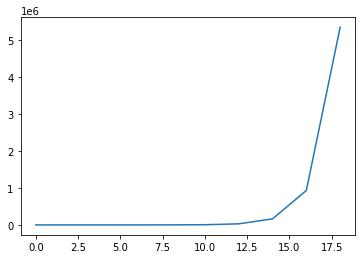

In [18]:
conds = []
x = []
for i in range(0, 10):
    conds.append(experiment(mono_poly, cheby_first_kind, i*2, 1))
    x.append(i * 2)
plt.plot(x, conds)
plt.show

In [29]:
experiment(mono_poly, mono_poly, 30, 1)

47.063111020466714

<function matplotlib.pyplot.show(close=None, block=None)>

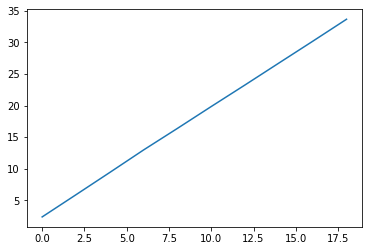

In [19]:
conds = []
x = []
for i in range(0, 10):
    conds.append(experiment(cheby_first_kind, cheby_first_kind, i*2, 1))
    x.append(i * 2)
plt.plot(x, conds)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

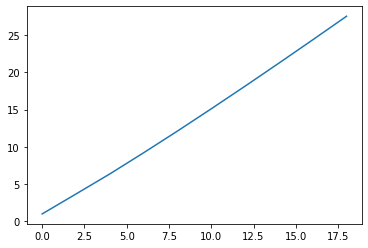

In [20]:
conds = []
x = []
for i in range(0, 10):
    conds.append(experiment(mono_poly, mono_poly, i*2, 1))
    x.append(i * 2)
plt.plot(x, conds)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

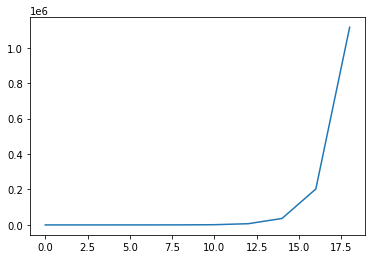

In [21]:
conds = []
x = []
for i in range(0, 10):
    conds.append(experiment(cheby_first_kind, mono_poly, i*2, 1))
    x.append(i * 2)
plt.plot(x, conds)
plt.show

In [22]:
experiment(cheby_first_kind, mono_poly, 8, 1)

243.95198338531648

In [44]:
a = cheby_first_kind(4, 1)

In [45]:
a.c_extract_map(a.base[1], a.base[1], 1)

1.00000000000000

In [46]:
x_0 = syms('x_0')
x_0 ** 2

x_0**2

In [47]:
10 / pi/2

5/pi

In [48]:
(a.base[4] * a.base[2]) / sqrt((1 - x_0 ** 2))

(2*x_0**2 - 1)*(8*x_0**4 - 8*x_0**2 + 1)/sqrt(1 - x_0**2)

In [54]:
f = lambdify(x_0, (a.base[4] * a.base[2]) / sqrt((1 - x_0 ** 2)))
integ.quad(f, -1, 1)

# integrate((a.base[4] * a.base[4]) / sqrt((1 - x_0 ** 2)), (x_0, -1, 1))

(-2.1394287251284634e-12, 4.272426055364603e-10)

In [55]:
a.base[4].coeff(a.base[2])

0

In [23]:
a = [[1, 2], [3, 4]]

In [24]:
a[0,0]

TypeError: list indices must be integers or slices, not tuple

In [25]:
x = syms('x')
y = syms('y')


In [26]:
T_2_1 = 1/8 * x**2 * y - 1/2 * y ** 2 - 1/2 * x

In [ ]:
T_2_2 = 